In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from scipy.stats import norm

In [2]:
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.distributions.normal as normal_distribution
import torch
import math

In [3]:
from data.catalog import DataCatalog
from models.catalog import MLModelCatalog

C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\s

[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


In [4]:
'''
sns.set_theme(style="whitegrid")
viz_dict = {
    "font.size": 16,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    "legend.fontsize": 14,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
} 
sns.set_context("notebook", rc=viz_dict)
import matplotlib.pyplot as plt
from matplotlib import rc

font = {'family': 'serif',
        'weight': 'bold',
        'serif': ['Palatino'],
        'size': 20}
rc('font', **font)
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams['axes.autolimit_mode']
'''

'\nsns.set_theme(style="whitegrid")\nviz_dict = {\n    "font.size": 16,\n    \'axes.titlesize\': 18,\n    \'axes.labelsize\': 16,\n    "legend.fontsize": 14,\n    "xtick.labelsize": 13,\n    "ytick.labelsize": 13,\n} \nsns.set_context("notebook", rc=viz_dict)\nimport matplotlib.pyplot as plt\nfrom matplotlib import rc\n\nfont = {\'family\': \'serif\',\n        \'weight\': \'bold\',\n        \'serif\': [\'Palatino\'],\n        \'size\': 20}\nrc(\'font\', **font)\nrc(\'text\', usetex=True)\nplt.rcParams[\'text.latex.preamble\'] = [r\'\x08oldmath\']\nplt.rcParams[\'axes.autolimit_mode\']\n'

In [5]:
## for Palatino and other serif fonts use:
import seaborn as sns
sns.set_theme(style="whitegrid")
#sns.set_context(font_scale=1.6)
viz_dict = {
    "font.size": 16,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    "legend.fontsize": 14,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
} 
sns.set_context("notebook", rc=viz_dict)
import matplotlib.pyplot as plt
from matplotlib import rc

font = {'family': 'serif',
        'weight': 'bold',
        'serif': ['Palatino'],
        'size': 20}
rc('font', **font)
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams['axes.autolimit_mode']

C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.


'data'

In [6]:
def gaussian_pdf(mean, var):
    pi = torch.tensor(math.pi)
    pdf = 1/(torch.sqrt(2*pi)) * torch.exp(- 0.5 * torch.divide( torch.square(-mean), var) )
    return pdf

In [7]:
current_dir = os.getcwd()
current_dir  = current_dir + '/recourse_invalidation_results/experiment_09_01_22/'

In [8]:
# Need to be in "C:\\Users\\fred0\\Documents\\project_robust_explanations\\RobustExplanations\\carla'

In [9]:
training_params_linear = {
    "adult": {"lr": 0.002, "epochs": 100, "batch_size": 1024},
    "compas": {"lr": 0.002, "epochs": 25, "batch_size": 128},
    "give_me_some_credit": {"lr": 0.002, "epochs": 50, "batch_size": 2048},
}
training_params_ann = {
    "adult": {"lr": 0.002, "epochs": 30, "batch_size": 1024},
    "compas": {"lr": 0.002, "epochs": 25, "batch_size": 25},
    "give_me_some_credit": {"lr": 0.002, "epochs": 50, "batch_size": 2048},
}
training_params = {"linear": training_params_linear, "ann": training_params_ann}

In [10]:
# This function obtains the weights from the linear model
def get_weight(model, intercept=False) -> np.array:
    
    # get weights and bias of linear layer for negative class 0
    coeffs_neg = model.raw_model.output.weight[0].detach().numpy()
    intercepts_neg = model.raw_model.output.bias[0].detach().numpy()

    # get weights and bias of linear layer for positive class 1
    coeffs_pos = model.raw_model.output.weight[1].detach().numpy()
    intercepts_pos = model.raw_model.output.bias[1].detach().numpy()

    coeffs = -(coeffs_neg - coeffs_pos)
    if intercept:
        intercepts = -(intercepts_neg - intercepts_pos)
        return coeffs, intercept
    else:
        return coeffs

def get_logit_score(prob):
    logit = np.log(prob/(1-prob))
    return logit

def get_omega(weight: np.array, action: np.array) -> np.array:
    # This function computes the cosine of the angle
    dot_product = np.dot(weight, action)
    norm_action = np.linalg.norm(action, ord=2)
    norm_weight = np.linalg.norm(weight, ord=2)
    omega = dot_product / (norm_action * norm_weight)
    return omega

def get_norms(action: np.array) -> np.array:
    norm_inf = np.linalg.norm(action, np.inf)
    norm_zero = np.linalg.norm(action, ord=0)
    norm_one = np.linalg.norm(action, ord=1)
    return norm_zero, norm_one, norm_inf

def compute_constant(model, factual: np.array, action: np.array, sigma: float) -> np.array:
    norm_action = np.linalg.norm(action, 2)
    prob_factual = model.raw_model(torch.tensor(factual).float()).detach().numpy()[1]
    logit_factual = get_logit_score(prob_factual)
    constant = logit_factual / (norm_action * sigma)
    return constant
    
def compute_upper_bound(model, factual: np.array, action: np.array, weight: np.array, sigma: float) -> np.array:
    omega = get_omega(weight, action)
    action_norm_zero, action_norm_one, action_norm_inf = get_norms(action)
    constant = compute_constant(model, factual, weight, sigma)
    y = constant + (omega/sigma) * (action_norm_one/np.sqrt(action_norm_zero))
    cdf = norm.cdf(y)
    lower_bound = 1 - cdf
    return lower_bound, omega

linear
Loaded model from C:\Users\fred0\carla\models\adult\linear.pt


C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\carla_recourse-0.0.4-py3.7.egg\carla\models\catalog\Linear_TORCH\model_linear.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


approx. acc: 0.8325688073394495
ar
wachter
gs
dice


C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\carla_recourse-0.0.4-py3.7.egg\carla\models\catalog\Linear_TORCH\model_linear.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


roar
arar
wachter_rip
linear
Loaded model from C:\Users\fred0\carla\models\compas\linear.pt
approx. acc: 0.8418664938431627
ar
wachter
gs
dice
roar


C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\carla_recourse-0.0.4-py3.7.egg\carla\models\catalog\Linear_TORCH\model_linear.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)
C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\carla_recourse-0.0.4-py3.7.egg\carla\models\catalog\Linear_TORCH\model_linear.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


arar
wachter_rip
linear
Loaded model from C:\Users\fred0\carla\models\give_me_some_credit\linear.pt
approx. acc: 0.9348036839554047
ar
wachter
gs


C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\carla_recourse-0.0.4-py3.7.egg\carla\models\catalog\Linear_TORCH\model_linear.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)
C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\carla_recourse-0.0.4-py3.7.egg\carla\models\catalog\Linear_TORCH\model_linear.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


dice
roar
arar
wachter_rip


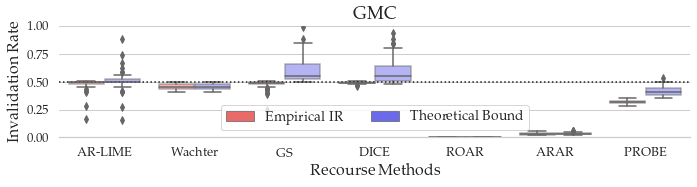

In [11]:
# color = 'nipy_spectral_r'
color = 'seismic_r'
alpha = 0.5
intarget = "0.3"
model_type = "linear"
width = "0"
sigma2 = "0.01"

backend = "pytorch"
hidden_width = "0"

#model_names = ['ar', 'wachter', 'gs', 'wachter_rip']
#model_names_plot = ['AR', 'Wachter', 'GS','EXPECT']
#data_names = ["adult", "compas", "give_me_some_credit"]
#data_names_plot = ["Adult", "Compas" , "GMC"]

model_names = ['ar', 'wachter', 'gs', 'dice', 'roar', 'arar', 'wachter_rip']
model_names_plot = ['AR-LIME', 'Wachter', 'GS', 'DICE', 'ROAR', 'ARAR', 'PROBE']
data_names = ["adult", "compas", "give_me_some_credit"]
data_names_plot = ["Adult", "Compas" , "GMC"]

for data_name in data_names:
    plt.close('all')
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))

    params = training_params[model_type][data_name]
    data = DataCatalog(data_name)
    model = MLModelCatalog(
        data, model_type, load_online=False, use_pipeline=True, backend=backend
    )
    model.train(
        learning_rate=params["lr"],
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        hidden_size=hidden_width,
    )
    model.use_pipeline = False

    ph1 = [] 
    ph2 = []
    ph3 = []

    if data_name == 'adult':
        data_plot_name = 'Adult'
    elif data_name == 'compas':
        data_plot_name = 'Compas'   
    elif data_name == 'give_me_some_credit':
        data_plot_name = 'GMC'

    jt = 0
    for model_name in model_names:
        print(model_name)

        if model_name == 'wachter_rip':
            intarget = "0.4"
        else:
            intarget = "0.5"

        # identify values for which no CE could be found!
        df2 = pd.read_csv(current_dir + '/' + model_name + '_' + data_name + '_' + model_type + '_' + width + '_sigma2_' + sigma2 + '_intarget_' + intarget + '/counterfactual.csv')
        df1 = pd.read_csv(current_dir + '/' + model_name + '_' + data_name + '_' + model_type + '_' + width + '_sigma2_' + sigma2 + '_intarget_' + intarget + '/factual.csv')
        df1 = df1.drop(columns=['prediction'])
        ce_class = df2['prediction'].values
        ce_class_idx = np.where(ce_class==1)[0]
        df2 = df2.drop(columns=['prediction'])
        df = pd.read_csv(current_dir + '/' + model_name + '_'+ data_name + '_' + model_type + '_' + width + '_sigma2_' + sigma2 + '_intarget_' + intarget + '/delta.csv')

        rips = df.values[ce_class_idx]
        actions = df2.values[ce_class_idx] - df1.values[ce_class_idx]
        x = df1.values[ce_class_idx]

        n_samples = x.shape[0] 
        uppers = []
        lowers = []
        probs = []

        for it in range(n_samples):
            sigma = np.sqrt(float(sigma2))
            factual = x[it]
            action = actions[it]
            cf = factual + action
            rip = rips[it][0]

            # Compute upper and lower bounds
            weight = get_weight(model, intercept=False)
            upper, omega = compute_upper_bound(model, factual, action, weight, sigma)

            if (rip <= upper+0.01):
                uppers.append(np.round(upper, 2))
                probs.append(np.round(rip, 2))

        ph1 = ph1 + probs + uppers
        n_samples = len(probs)

        upper_names = list(np.repeat('Theoretical Bound', n_samples).reshape(-1, 1))
        rip_names = list(np.repeat('Empirical IR', n_samples).reshape(-1, 1))
        #lower_names = list(np.repeat('Lower', n_samples).reshape(-1, 1))
        ph2 = ph2 + rip_names + upper_names 

        method_name = list(np.repeat(model_names_plot[jt], n_samples*2))
        ph3 = ph3 + method_name

        jt += 1

    dframe = np.c_[ph1, ph2, ph3]
    dframe = pd.DataFrame(dframe)
    dframe.columns = ['Invalidation Rate', 'Type', 'Recourse Methods']
    dframe["Invalidation Rate"] = pd.to_numeric(dframe["Invalidation Rate"])

    f = sns.boxplot(y="Invalidation Rate", x="Recourse Methods", hue="Type", 
                    data=dframe, ax=ax, palette=color, boxprops=dict(alpha=alpha))    
    f.legend(ncol=2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axhline(0.5, linestyle='dotted', label='Base', color='k')
    ax.set_ylim([0,1])
    ax.set_title(data_plot_name)

    fig.tight_layout()
    fig.savefig(current_dir + '/' + 'bounds_' + data_name +  '_' + "all_linear_models" + '_' + 'width_' + width + '_sigma2_' + sigma2 + '.pdf')